# Load the dataframe containing proper elements

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import ngboost
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt

from hadden_theory.test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian, calc_g0_and_s0
from hadden_theory import test_particle_secular_hamiltonian
# hack to make pickle load work
import sys
sys.modules['test_particle_secular_hamiltonian'] = test_particle_secular_hamiltonian

try:
	plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
	pass

In [10]:
from pathlib import Path
Path("tables_for_analysis").mkdir(exist_ok=True)

In [11]:
import pickle
with open("hadden_theory/solar_system_synthetic_solution.bin","rb") as fi:
	solar_system_synthetic_theory=pickle.load(fi)

In [12]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
	solar_system_synthetic_theory.masses,
	solar_system_synthetic_theory.semi_major_axes,
	solar_system_synthetic_theory.omega_vector,
	[truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
	[truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

In [20]:
merged_df_all = pd.read_csv("merged_elements.csv")

/tmp/ipykernel_549635/884076697.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df_all = pd.read_csv("merged_elements.csv")


In [2]:
merged_df = pd.read_csv("tables_for_analysis/uncertainty_asteroid_elements.csv")
merged_df.columns
merged_df

,Unnamed: 0,Des'n,g,s,propa,prope,propsini
0,0,K23Q65H-0,39.155407,-40.617037,2.393283,0.080897,0.028574
1,1,K23Q65H-1,39.416352,-40.836035,2.400683,0.074695,0.033312
2,2,K23Q65H-10,39.747412,-41.289676,2.411898,0.073752,0.033862
3,3,K23Q65H-11,39.470774,-40.801988,2.399221,0.075767,0.033186
4,4,K23Q65H-12,39.045902,-40.510004,2.390086,0.079456,0.032523
...,...,...,...,...,...,...,...
195,195,K23Q67X-95,110.752103,-83.816948,3.122676,0.023207,0.075664
196,196,K23Q67X-96,113.164686,-84.319339,3.127736,0.071530,0.100726
197,197,K23Q67X-97,112.729449,-84.181573,3.127018,0.043467,0.109445
198,198,K23Q67X-98,112.184492,-84.128326,3.125656,0.029844,0.087858


# Get all of the osculating terms

In [3]:
import pandas as pd
from IPython.display import clear_output
from scipy.optimize import minimize

import rebound as rb

from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from pathlib import Path
import os
import sympy

dataset_path = Path('integrations') / 'uncertainty_testing'
sims = list(dataset_path.glob('*.sa'))
desn_list = []
a_list = []
e_list = []
inc_list = []
omega_list = []
Omega_list = []
for filename in sims:
	results = get_simarchive_integration_results(str(filename), coordinates='heliocentric')
	desn = str(filename).split("/")[-1].split(".")[0].split("_")[-1]
	desn_list.append(desn)
	a_list.append(results["a"][-1][0])
	e_list.append(results["e"][-1][0])
	inc_list.append(results["inc"][-1][0])
	omega_list.append(results["omega"][-1][0])
	Omega_list.append(results["Omega"][-1][0])

/home/miniconda3/envs/lshen/lib/python3.12/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.6. You are currently using REBOUND Version 4.4.10.
  warnings.warn(message, RuntimeWarning)
/home/miniconda3/envs/lshen/lib/python3.12/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/home/miniconda3/envs/lshen/lib/python3.12/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Encountered unknown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)
/home/miniconda3/envs/lshen/lib/python3.12/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchro

In [4]:
df_osculating = pd.DataFrame({
    "Des'n": desn_list,
    "a": a_list,
    "e": e_list,
    "Incl.": inc_list,
    "Peri.": omega_list,
	"Node": Omega_list
})
df_osculating

,Des'n,a,e,Incl.,Peri.,Node
0,K23Q65H-14,2.404316,0.106807,0.042731,3.427121,2.330392
1,K23Q67X-84,3.130013,0.080027,0.104253,5.654324,-0.027865
2,K23Q65H-72,2.395534,0.110591,0.042105,3.421551,2.324080
3,K23Q67X-62,3.123794,0.076543,0.104466,5.541689,-0.029130
4,K23Q67X-31,3.123640,0.075134,0.104717,5.512769,-0.030789
...,...,...,...,...,...,...
195,K23Q65H-44,2.397130,0.109622,0.042231,3.425895,2.325331
196,K23Q67X-60,3.128482,0.079363,0.104257,5.630222,-0.027834
197,K23Q65H-93,2.375067,0.117486,0.040749,3.430443,2.310281
198,K23Q67X-26,3.127073,0.077987,0.104418,5.593596,-0.028872


In [5]:
merged_df = pd.merge(merged_df, df_osculating, on = "Des'n")
merged_df = merged_df.drop(columns=[col for col in merged_df.columns if col.endswith('_y')])
merged_df = merged_df.rename(columns={
    col: col[:-2] for col in merged_df.columns if col.endswith('_x')
})
merged_df["Incl."] = merged_df["Incl."] * 180/np.pi
merged_df["Peri."] = merged_df["Peri."] * 180/np.pi
merged_df["Node"] = merged_df["Node"] * 180/np.pi

In [22]:
# have the table for linear predictions
merged_df.to_csv("tables_for_analysis/uncertainty_asteroid_testing.csv")

# After linear prediction

In [7]:
integration_path = Path("integrations/uncertainty_testing_linear")
file_names = list(integration_path.glob("*.npz"))
rows = []

for i in range(len(file_names)):
	soln_h = np.load(file_names[i])
	prope_value = soln_h["u"]
	propsini_value = soln_h["v"]
	des_n = file_names[i].stem.replace("integration_results_", "")
	rows.append([des_n, np.abs(prope_value), np.abs(propsini_value)])

df_h = pd.DataFrame(rows, columns=["Des'n", "prope_h", "propsini_h"])
df_h

,Des'n,prope_h,propsini_h
0,K23Q67X-78,0.097794,0.053839
1,K23Q65H-13,0.115491,0.023651
2,K23Q65H-86,0.114875,0.023677
3,K23Q65H-97,0.114125,0.023682
4,K23Q65H-62,0.113104,0.023656
...,...,...,...
195,K23Q67X-5,0.097029,0.054072
196,K23Q67X-35,0.097047,0.054006
197,K23Q65H-98,0.113446,0.023653
198,K23Q67X-98,0.097516,0.054019


In [8]:
merged_df = pd.merge(merged_df, df_h, on = "Des'n")
merged_df = merged_df.drop(columns=[col for col in merged_df.columns if col.endswith('_y')])

# Rename columns that end with '_x' by stripping '_x'
merged_df = merged_df.rename(columns={
    col: col[:-2] for col in merged_df.columns if col.endswith('_x')
})

merged_df

,Unnamed: 0,Des'n,g,s,propa,prope,propsini,a,e,Incl.,Peri.,Node,prope_h,propsini_h
0,0,K23Q65H-0,39.155407,-40.617037,2.393283,0.080897,0.028574,2.389981,0.112502,2.391384,196.143293,132.947327,0.115721,0.023646
1,1,K23Q65H-1,39.416352,-40.836035,2.400683,0.074695,0.033312,2.397218,0.108485,2.422461,197.091970,133.253279,0.112747,0.023687
2,2,K23Q65H-10,39.747412,-41.289676,2.411898,0.073752,0.033862,2.408497,0.106262,2.462431,195.620936,133.670069,0.109780,0.023704
3,3,K23Q65H-11,39.470774,-40.801988,2.399221,0.075767,0.033186,2.395686,0.109544,2.415503,196.734303,133.186173,0.113456,0.023671
4,4,K23Q65H-12,39.045902,-40.510004,2.390086,0.079456,0.032523,2.386756,0.113562,2.379049,196.261653,132.820754,0.116747,0.023641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,K23Q67X-95,110.752103,-83.816948,3.122676,0.023207,0.075664,3.121606,0.074873,5.994418,314.696204,-1.725944,0.097684,0.054057
196,196,K23Q67X-96,113.164686,-84.319339,3.127736,0.071530,0.100726,3.126964,0.078320,5.979722,320.798062,-1.636284,0.097586,0.053933
197,197,K23Q67X-97,112.729449,-84.181573,3.127018,0.043467,0.109445,3.126176,0.076769,5.992581,318.821905,-1.719237,0.097264,0.054051
198,198,K23Q67X-98,112.184492,-84.128326,3.125656,0.029844,0.087858,3.125091,0.076651,5.989538,318.131802,-1.697977,0.097516,0.054019


In [13]:
merged_df["g0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[0])
merged_df["s0"] = merged_df['a'].apply(lambda x: calc_g0_and_s0(x, simpler_secular_theory)[1])

In [14]:
merged_df["prope_h"] = np.abs(merged_df["prope_h"])
merged_df["propsini_h"] = np.abs(merged_df["propsini_h"])
merged_df['prope_h'] = pd.to_numeric(merged_df['prope_h'], errors='coerce')
merged_df['propsini_h'] = pd.to_numeric(merged_df['propsini_h'], errors='coerce')
merged_df['Node'] = pd.to_numeric(merged_df['Node'], errors='coerce')
merged_df['Peri.'] = pd.to_numeric(merged_df['Peri.'], errors='coerce')
merged_df['ecospo'] = merged_df['prope_h']*np.cos((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['esinpo'] = merged_df['prope_h']*np.sin((merged_df['Node']+merged_df['Peri.'])*np.pi/180)
merged_df['sinicosO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.cos(merged_df['Node']*np.pi/180)
merged_df['sinisinO'] = np.sin(merged_df['propsini_h']*np.pi/180)*np.sin(merged_df['Node']*np.pi/180)

In [15]:
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'a']
#features = ['M', 'Peri.', 'Node', 'Incl.', 'e', 'propa']
#features = ['M', 'Node', 'Incl.', 'ecospo', 'esinpo', 'propa']
features_e = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 'g0', 'prope_h']
features_inc = ['sinicosO', 'sinisinO', 'ecospo', 'esinpo', 'propa', 's0', 'propsini_h']
data_e = merged_df[features_e]
data_inc = merged_df[features_inc]
dela = merged_df['propa']-merged_df['a']
dele = merged_df['prope']-merged_df['e']
delsini = merged_df['propsini']-np.sin(merged_df['Incl.']*np.pi/180)
delg = merged_df['g0'] - merged_df['g']
s = merged_df['s']

# NGBoost Running

In [16]:
import pickle
from pathlib import Path

ngb_e = Path("models/best_model.ngb")
with ngb_e.open("rb") as f:
	final_model_e = pickle.load(f)
	
ngb_inc = Path("models/best_model_inc.ngb")
with ngb_inc.open("rb") as f:
	final_model_inc = pickle.load(f)

In [17]:
pred_dist = final_model_e.pred_dist(data_e)

pred_e = pred_dist.loc
std_e = pred_dist.scale

pred_dist = final_model_inc.pred_dist(data_inc)

pred_inc = pred_dist.loc
std_inc = pred_dist.scale

In [18]:
merged_df["pred_e"] = pred_e + merged_df["e"]
merged_df["pred_sini"] = pred_inc + np.sin(merged_df["Incl."]*np.pi/180)

# Plotting

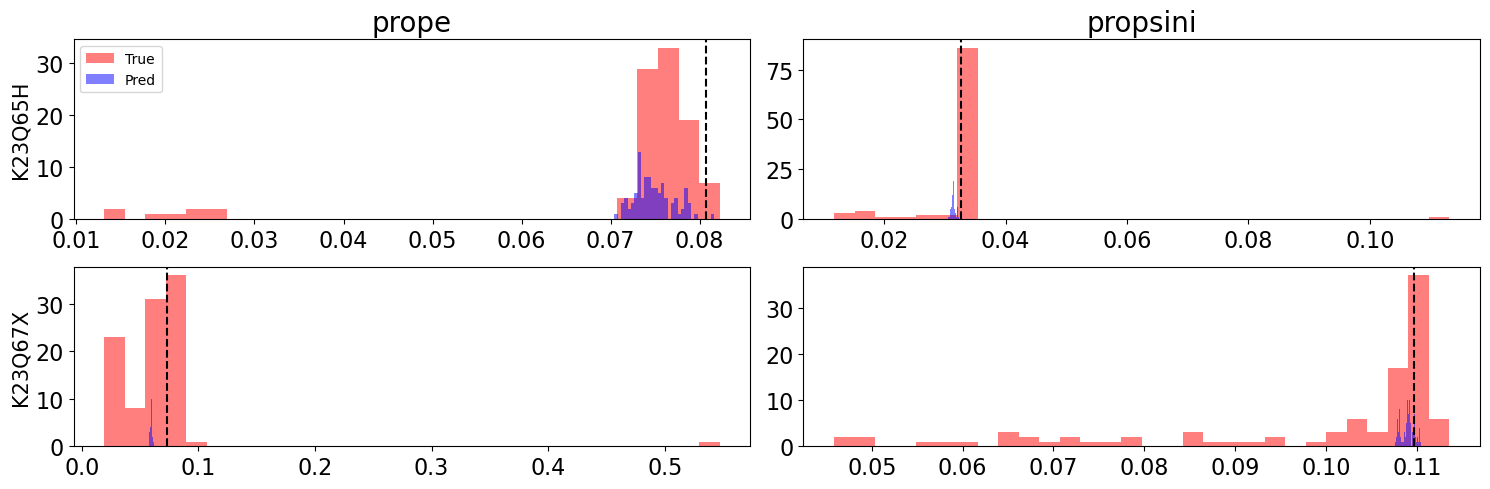

In [21]:
import matplotlib.pyplot as plt

target_asteroids = ["K23Q65H", "K23Q67X"]
qtys_true = ["prope", "propsini"]
qtys_pred = ["pred_e", "pred_sini"]

fig, axs = plt.subplots(len(target_asteroids), len(qtys_true), figsize=(15, 5))

for i, asteroid in enumerate(target_asteroids):
    row = merged_df_all[merged_df_all["Des'n"] == asteroid]
    axs[i, 0].set_ylabel(asteroid, size=15)

    for j, (true_col, pred_col) in enumerate(zip(qtys_true, qtys_pred)):
        if i == 0:
            axs[i, j].set_title(true_col, size=20)
        clones_df = merged_df[merged_df["Des'n"].str.contains(asteroid)]
        axs[i, j].hist(clones_df[true_col], bins=30, color="red", alpha=0.5, label="True")
        axs[i, j].hist(clones_df[pred_col], bins=30, color="blue", alpha=0.5, label="Pred")
        axs[i, j].axvline(row[true_col].item(), linestyle="--", color="black")
        axs[i, j].tick_params(axis='both', labelsize=16)
        if i == 0 and j == 0:
            axs[i, j].legend()

plt.tight_layout()
plt.show()
